# 01 Introduction to PYRO

In [2]:
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro

In [3]:
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.8.2')

pyro.enable_validation(True)
pyro.set_rng_seed(1)
logging.basicConfig(format='%(message)s', level=logging.INFO)

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')
smoke_test

False

In [4]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])
df.head()

,cont_africa,rugged,rgdppc_2000
2,1,0.858,7.492609
4,0,3.427,8.216929
7,0,0.769,9.933263
8,0,0.775,9.407032
9,0,2.688,7.792343


In [5]:
train = torch.tensor(df.values, dtype=torch.float)
cont_africa, rugged, log_gdp = train[:, 0], train[:, 1], train[:, 2]

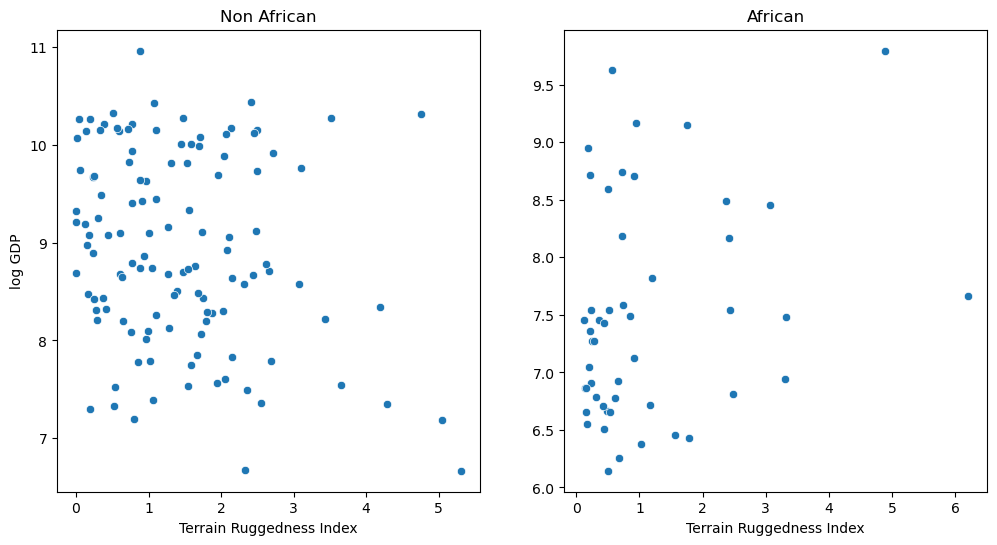

In [6]:
african = df[df['cont_africa'] == 1]
non_african = df[df['cont_africa'] == 0]
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.scatterplot(x=non_african['rugged'],
                y=non_african['rgdppc_2000'])
plt.ylabel('log GDP')
plt.xlabel('Terrain Ruggedness Index')
plt.title('Non African')
plt.subplot(122)
sns.scatterplot(x=african['rugged'],
                y=african['rgdppc_2000'])
plt.ylabel('')
plt.xlabel('Terrain Ruggedness Index')
plt.title('African')
plt.show()
plt.close()

$$ \mu = \alpha + \beta _{a} \cdot africa + \beta _r \cdot rugedness + \beta _{ar} \cdot africa \cdot rugedness $$

In [7]:
import pyro.distributions as D
import pyro.distributions.constraints as C 

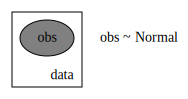

In [8]:
def simple_model(cont_africa, rugged, log_gdp=None):
    a = pyro.param('a', lambda: torch.randn(()))
    ba = pyro.param('ba', lambda: torch.randn(()))
    br = pyro.param('br', lambda: torch.randn(()))
    bar = pyro.param('bar', lambda: torch.randn(()))
    sigma = pyro.param('sigma', lambda: torch.ones(()), constraint=C.positive)
    
    mean = a + ba * cont_africa + br * rugged + bar * cont_africa * rugged 
    
    with pyro.plate('data', len(rugged)):
        return pyro.sample('obs', D.Normal(mean, sigma), obs=log_gdp)
    
pyro.render_model(simple_model, model_args=(cont_africa, rugged, log_gdp), render_distributions=True)

    

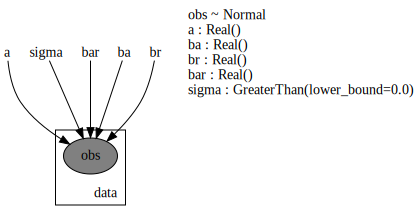

In [9]:
pyro.render_model(simple_model, model_args=(cont_africa, rugged, log_gdp), 
                  render_distributions=True, render_params=True)

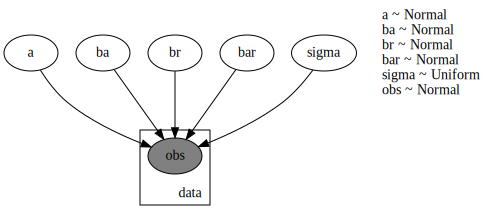

In [10]:
def model(cont_africa, rugged, log_gdp=None):
    a = pyro.sample('a', D.Normal(0., 10.))
    ba = pyro.sample('ba', D.Normal(0., 1.))
    br = pyro.sample('br', D.Normal(0., 1.))
    bar = pyro.sample('bar', D.Normal(0., 1.))
    sigma = pyro.sample('sigma', D.Uniform(0., 10.))
    
    mean = a + ba * cont_africa + br * rugged + bar * cont_africa * rugged 
    
    with pyro.plate('data', len(rugged)):
        return pyro.sample('obs', D.Normal(mean, sigma), obs=log_gdp)
    
pyro.render_model(model, model_args=(cont_africa, rugged, log_gdp), render_distributions=True)

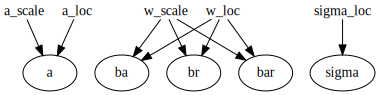

In [11]:
def custom_guide(cont_africa, rugged, log_gdp=None):
    a_loc = pyro.param('a_loc', lambda: torch.tensor(0.))
    a_scale = pyro.param('a_scale', lambda: torch.tensor(1.),
                         constraint=C.positive)
    sigma_loc = pyro.param('sigma_loc', lambda: torch.tensor(1),
                           constraint=C.positive)
    w_loc = pyro.param('w_loc', lambda: torch.randn(3))
    w_scale = pyro.param('w_scale', lambda: torch.ones(3),
                         constraint=C.positive)
    a = pyro.sample('a', D.Normal(a_loc, a_scale))
    ba = pyro.sample('ba', D.Normal(w_loc[0], w_scale[0]))
    br = pyro.sample('br', D.Normal(w_loc[1], w_scale[1]))
    bar = pyro.sample('bar', D.Normal(w_loc[2], w_scale[2]))
    sigma = pyro.sample('sigma', D.Normal(sigma_loc, torch.tensor(0.5)))
    
    return {'a': a, 'ba': ba, 'br': br, 'bar': bar, 'sigma': sigma}

pyro.render_model(custom_guide, model_args=(cont_africa, rugged, log_gdp), render_params=True)    

```js
auto_guide = pyro.infer.autoguide.AutoNormal(model)
```

$$ ELBO \equiv \mathbb{E}_{q_{\phi} (\bold{z})} [\log p_\theta(\bold{x}, \bold{z}) - \log q_\phi (\bold{z})] $$

In [15]:
import pyro.infer.autoguide, pyro.infer, pyro.optim

In [16]:
adam = pyro.optim.Adam({'lr': 0.02})
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, custom_guide, adam, elbo)

In [20]:
from tqdm import trange, tqdm

In [52]:
pyro.clear_param_store()

auto_guide = pyro.infer.autoguide.AutoNormal(model)
adam = pyro.optim.Adam({'lr': 0.02})
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

losses = []
pbar = trange(1000)
for step in pbar:
    loss = svi.step(cont_africa, rugged, log_gdp)
    losses.append(loss)
    if step % 100 == 0:
        pbar.set_description(f'loss: {loss:.2f}')


loss: 247.08: 100%|██████████| 1000/1000 [00:11<00:00, 84.29it/s]


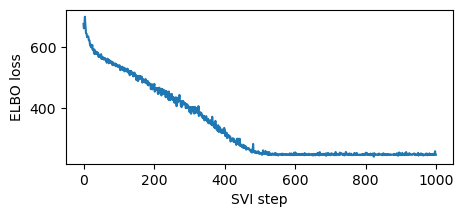

In [53]:
plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss")
plt.show()
plt.close()

In [54]:
for name, value in pyro.get_param_store().items():
    print(name, value.item())

AutoNormal.locs.a 9.207015037536621
AutoNormal.scales.a 0.06847474724054337
AutoNormal.locs.ba -1.8231754302978516
AutoNormal.scales.ba 0.12781356275081635
AutoNormal.locs.br -0.16849444806575775
AutoNormal.scales.br 0.04617444798350334
AutoNormal.locs.bar 0.33703580498695374
AutoNormal.scales.bar 0.08604834973812103
AutoNormal.locs.sigma -2.2285573482513428
AutoNormal.scales.sigma 0.05221838131546974


In [55]:
with pyro.plate('samples', 800, dim=-1):
    samples = auto_guide(cont_africa, rugged)
    
g_african = samples['br'] + samples['bar']
g_nafrican = samples['br']

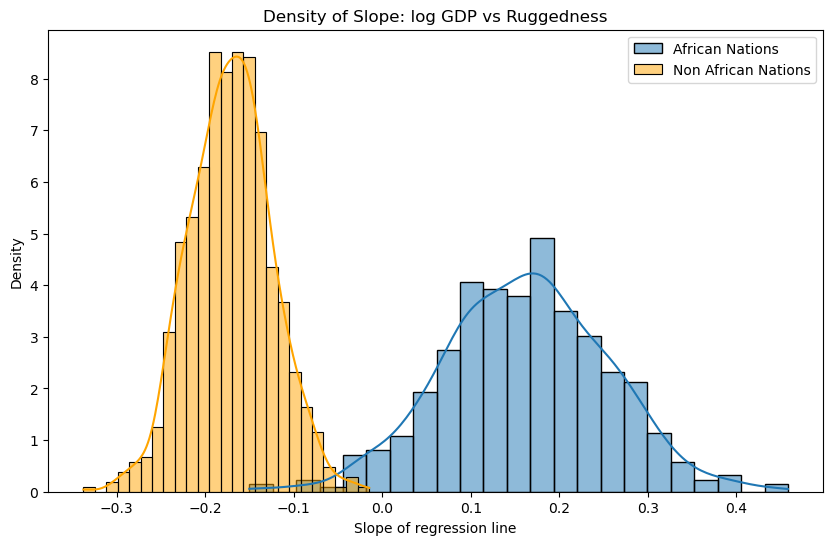

In [56]:
plt.figure(figsize=(10, 6))
sns.histplot(g_african.detach().numpy(), kde=True, stat='density', label='African Nations')
sns.histplot(g_nafrican.detach().numpy(), kde=True, stat='density', label='Non African Nations', 
             color='orange')
plt.legend()
plt.xlabel('Slope of regression line')
plt.title('Density of Slope: log GDP vs Ruggedness')
plt.show()
plt.close()

In [35]:
predictive = pyro.infer.Predictive(model, guide=auto_guide, num_samples=800)
svi_samples = predictive(cont_africa, rugged, log_gdp=None)
svi_gdp = svi_samples['obs']

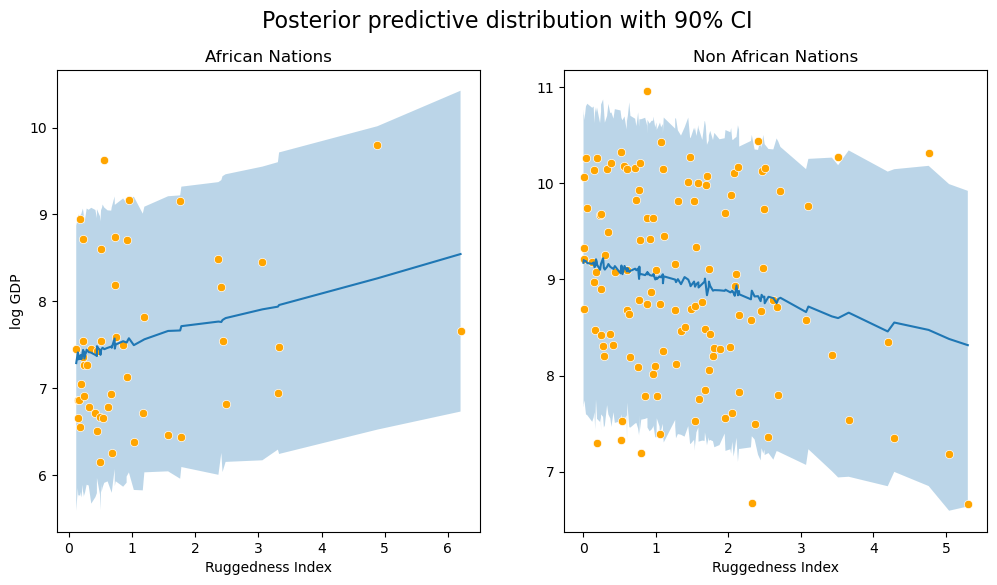

In [48]:
predictions = pd.DataFrame({
    'cont_africa': cont_africa,
    'rugged': rugged,
    'y_mean': svi_gdp.mean(0).detach().numpy(),
    'y_5': svi_gdp.quantile(0.05, dim=0).detach().numpy(),
    'y_95': svi_gdp.quantile(0.95, dim=0).detach().numpy(),
    'true_gdp': log_gdp
})

african = predictions[predictions['cont_africa'] == 1].sort_values('rugged')
nafrican = predictions[predictions['cont_africa'] == 0].sort_values('rugged')

plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.lineplot(x='rugged', y='y_mean', data=african)
plt.fill_between(african.rugged, african.y_5, african.y_95, alpha=0.3)
sns.scatterplot(x='rugged', y='true_gdp', data=african, color='orange')
plt.xlabel('Ruggedness Index')
plt.ylabel('log GDP')
plt.title('African Nations')

plt.subplot(122)
sns.lineplot(x='rugged', y='y_mean', data=nafrican)
plt.fill_between(nafrican.rugged, nafrican.y_5, nafrican.y_95, alpha=0.3)
sns.scatterplot(x='rugged', y='true_gdp', data=nafrican, color='orange')
plt.xlabel('Ruggedness Index')
plt.ylabel('')
plt.title('Non African Nations')

plt.suptitle('Posterior predictive distribution with 90% CI', fontsize=16)
plt.show()
plt.close()

## Regression with Full Rank guide

In [49]:
mvn_guide = pyro.infer.autoguide.AutoMultivariateNormal(model)

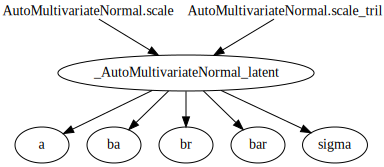

In [51]:
pyro.render_model(mvn_guide, model_args=(cont_africa, rugged, log_gdp), render_params=True)


In [58]:
pyro.clear_param_store()

mvn_guide = pyro.infer.autoguide.AutoMultivariateNormal(model)
adam = pyro.optim.Adam({'lr': 0.02})
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, mvn_guide, adam, elbo)

losses = []
pbar = trange(1000)
for step in pbar:
    loss = svi.step(cont_africa, rugged, log_gdp)
    losses.append(loss)
    if step % 100 == 0:
        pbar.set_description(f'loss: {loss:.2f}')

loss: 247.33: 100%|██████████| 1000/1000 [00:09<00:00, 101.67it/s]


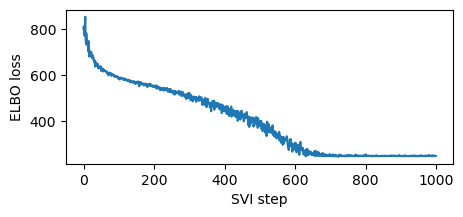

In [59]:
plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss")
plt.show()
plt.close()

In [61]:
with pyro.plate("samples", 800, dim=-1):
    mvn_samples = mvn_guide(cont_africa, rugged)

mvn_gamma_within_africa = mvn_samples["br"] + mvn_samples["bar"]
mvn_gamma_outside_africa = mvn_samples["br"]

# Interface note: reuse guide samples for prediction by passing them to Predictive
# via the posterior_samples keyword argument instead of passing the guide as above
assert "obs" not in mvn_samples
mvn_predictive = pyro.infer.Predictive(model, posterior_samples=mvn_samples)
mvn_predictive_samples = mvn_predictive(cont_africa, rugged, log_gdp=None)

mvn_gdp = mvn_predictive_samples["obs"]

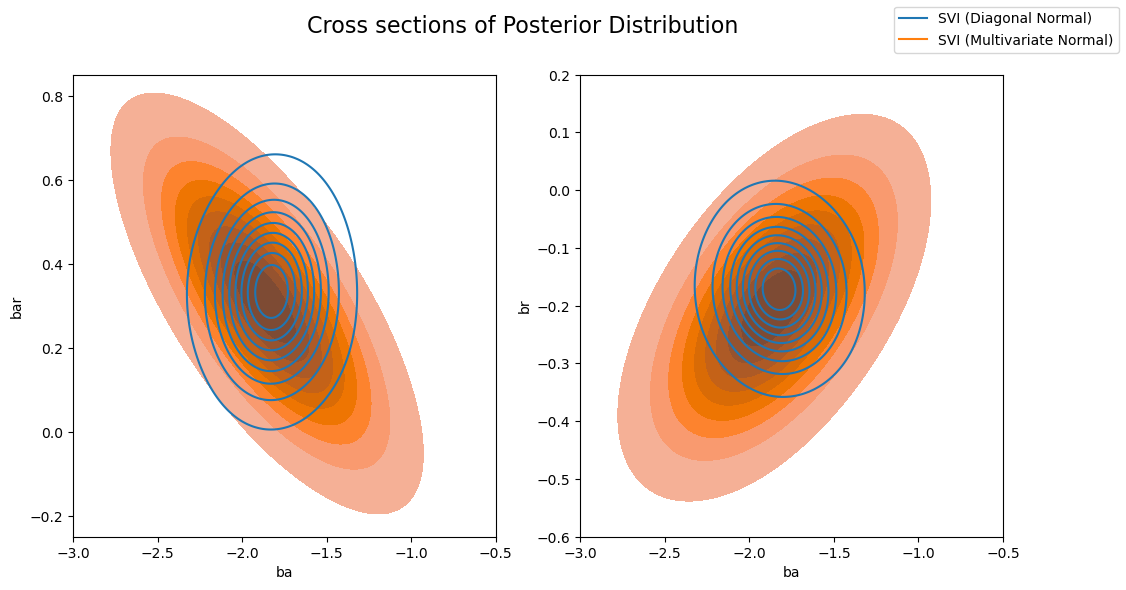

In [70]:
svi_samples = {k: v.detach().numpy() for k, v in samples.items()}
svi_mvn_samples = {k: v.detach().numpy() for k, v in mvn_samples.items()}

plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.kdeplot(x=svi_samples['ba'], y=svi_samples['bar'], bw_adjust=4)
sns.kdeplot(x=svi_mvn_samples['ba'], y=svi_mvn_samples['bar'], shade=True, bw_adjust=4)
plt.axis([-3, -0.5, -0.25, 0.85])
plt.xlabel('ba')
plt.ylabel('bar')

plt.subplot(122)
sns.kdeplot(x=svi_samples['ba'], y=svi_samples['br'], bw_adjust=4)
sns.kdeplot(x=svi_mvn_samples['ba'], y=svi_mvn_samples['br'], shade=True, bw_adjust=4)
plt.axis([-3, -0.5, -0.6, 0.2])
plt.xlabel('ba')
plt.ylabel('br')

plt.suptitle('Cross sections of Posterior Distribution', fontsize=16)
for label, color in zip(["SVI (Diagonal Normal)", "SVI (Multivariate Normal)"], sns.color_palette()[:2]):
    plt.plot([], [],
                label=label, color=color)
plt.figlegend(loc='upper right')
plt.show()
plt.close()


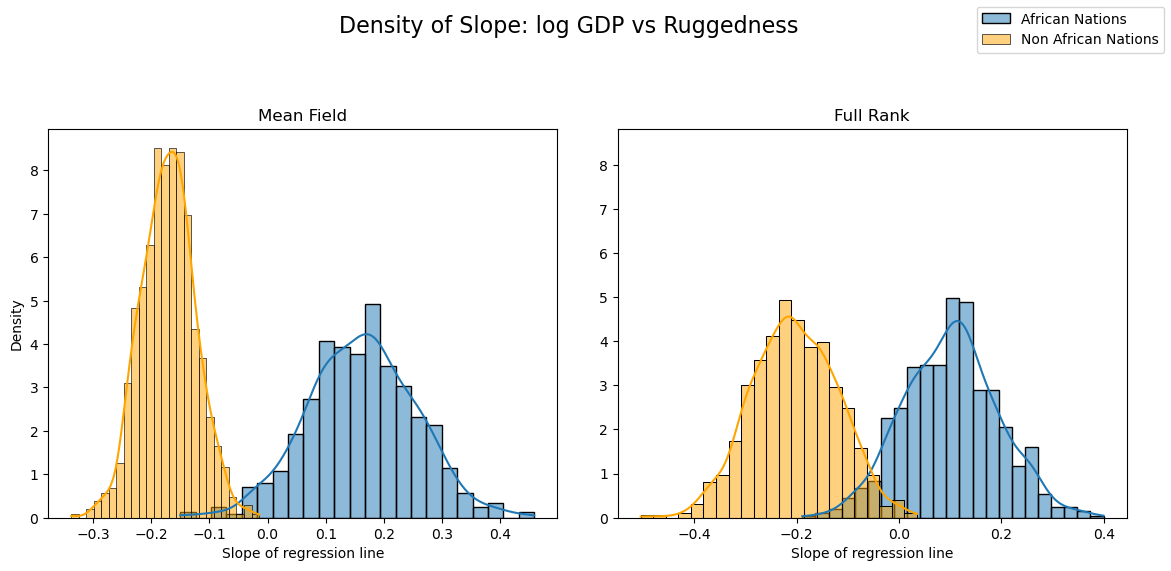

In [86]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.histplot(g_african.detach().numpy(), kde=True, stat='density', label='African Nations')
sns.histplot(g_nafrican.detach().numpy(), kde=True, stat='density', label='Non African Nations', 
             color='orange')
plt.xlabel('Slope of regression line')
plt.title('Mean Field')

plt.subplot(122)
sns.histplot(mvn_gamma_within_africa.detach().numpy(), kde=True, stat='density')
sns.histplot(mvn_gamma_outside_africa.detach().numpy(), kde=True, stat='density', 
             color='orange')
plt.xlabel('Slope of regression line')
plt.ylabel('')
plt.ylim(0, 8.8)
plt.title('Full Rank')


plt.suptitle('Density of Slope: log GDP vs Ruggedness', fontsize=16)
plt.figlegend(loc='upper right')
plt.tight_layout(pad=3)
plt.show()
plt.close()

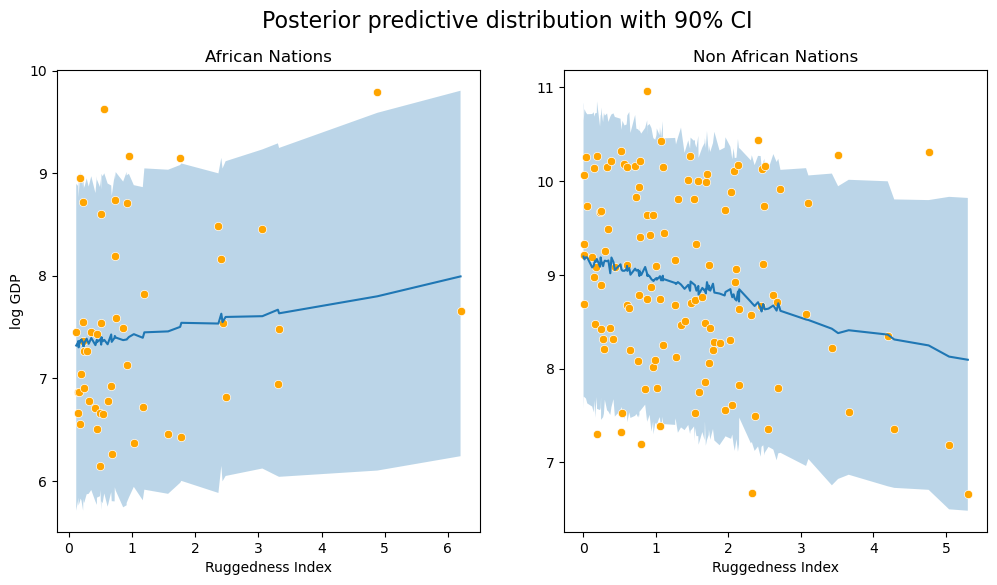

In [87]:
predictions = pd.DataFrame({
    'cont_africa': cont_africa,
    'rugged': rugged,
    'y_mean': mvn_gdp.mean(0).detach().numpy(),
    'y_5': mvn_gdp.quantile(0.05, dim=0).detach().numpy(),
    'y_95': mvn_gdp.quantile(0.95, dim=0).detach().numpy(),
    'true_gdp': log_gdp
})

african = predictions[predictions['cont_africa'] == 1].sort_values('rugged')
nafrican = predictions[predictions['cont_africa'] == 0].sort_values('rugged')

plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.lineplot(x='rugged', y='y_mean', data=african)
plt.fill_between(african.rugged, african.y_5, african.y_95, alpha=0.3)
sns.scatterplot(x='rugged', y='true_gdp', data=african, color='orange')
plt.xlabel('Ruggedness Index')
plt.ylabel('log GDP')
plt.title('African Nations')

plt.subplot(122)
sns.lineplot(x='rugged', y='y_mean', data=nafrican)
plt.fill_between(nafrican.rugged, nafrican.y_5, nafrican.y_95, alpha=0.3)
sns.scatterplot(x='rugged', y='true_gdp', data=nafrican, color='orange')
plt.xlabel('Ruggedness Index')
plt.ylabel('')
plt.title('Non African Nations')

plt.suptitle('Posterior predictive distribution with 90% CI', fontsize=16)
plt.show()
plt.close()